In [1]:
import seisbench.data as sbd

import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch

from dataset_creation.utils import create_loader_by_phase_and_length
from snr.calc_snr import calc_batch_snr, get_high_snr_traces

## Requirements and Configuration

The extracted high SNR traces should be taken from the following dataset ('ethz', 'geofon'):

In [2]:
DATASETS_ORIGINS = ['ethz', 'geofon']
dataset_origin = 'geofon'
assert dataset_origin in DATASETS_ORIGINS, f'Expected dataset one of {DATASETS_ORIGINS}. Got {dataset_origin}.'

Which partition of the data to use (train, dev, test)?

In [3]:
PARTITION_TO_USE = 'test'

In [4]:
SBD_CLASSES={'ethz':sbd.ETHZ, 'geofon':sbd.GEOFON}
SBD_CLASS=SBD_CLASSES[dataset_origin]
print(f'The corresponding Seisbench Model Type is: {SBD_CLASS}')

The corresponding Seisbench Model Type is: <class 'seisbench.data.geofon.GEOFON'>


In [5]:
NUM_SAMPLES=3001               # Trace sample length - If the dataset is built for phasenet: 3001 If it is for EQTransformer: 6000
PHASE_LABEL = 'P' # 'S'        # What phase are we interested in. The SNR estimation will be based on its channel
SAMPLING_RATE = 100            # Sampling Rate - PhaseNet and EQTransformer expect 100Hz
SNR_THRESHOLD = 20             # A trace with SNR level above this threshold will be considered high and is a potential candidate to the high SNR dataset
BATCH_SIZE=1000                # Number of traces that will be loaded at a single iteration

Browse the path the generated dataset will be saved:

In [6]:
SAVE_TO_PATH=f'/home/moshe/datasets/GFZ/noisy_datasets/{dataset_origin}_trainset_{NUM_SAMPLES}_sample_joachim_noises_energy_ratio_snr/'
assert os.path.exists(SAVE_TO_PATH), f'Path {SAVE_TO_PATH} does not exist'

Browse the path targets file:

In [7]:
TARGETS_PATH = f'/home/moshe/datasets/GFZ/targets/{dataset_origin}/'
assert os.path.exists(TARGETS_PATH), f'Path {TARGETS_PATH} does not exist'

Uncomment relevant lines if downloading targets is needed

In [8]:
# !mkdir targets
# !mkdir targets/ethz
# !mkdir targets/geofon
#
# #ethz
# !wget https://dcache-demo.desy.de:2443/Helmholtz/HelmholtzAI/SeisBench/auxiliary/pick-benchmark/targets/ethz/task1.csv
# !wget https://dcache-demo.desy.de:2443/Helmholtz/HelmholtzAI/SeisBench/auxiliary/pick-benchmark/targets/ethz/task23.csv
# !mv *.csv targets/ethz
#
# #geofon
# !wget https://dcache-demo.desy.de:2443/Helmholtz/HelmholtzAI/SeisBench/auxiliary/pick-benchmark/targets/geofon/task1.csv
# !wget https://dcache-demo.desy.de:2443/Helmholtz/HelmholtzAI/SeisBench/auxiliary/pick-benchmark/targets/geofon/task23.csv
# !mv *.csv targets/geofon

## Download Data and Load to Memory

### Load Dataset

In [9]:
# Take only test data
tr, dv, ts = SBD_CLASS(sampling_rate=SAMPLING_RATE, force=True).train_dev_test()
PARTITIONS = {'train':tr, 'dev':dv, 'test':ts}

data = PARTITIONS[PARTITION_TO_USE]
print(data)

GEOFON - 86261 traces


### Create Data Loader

In [10]:
loader, num_dataset_traces = create_loader_by_phase_and_length(phase_label=PHASE_LABEL, trace_length=NUM_SAMPLES, targets_path=TARGETS_PATH, batch_size=BATCH_SIZE)
print(f'There are {num_dataset_traces} traces in the resulting dataset.')
print(f'Created a dataloader that loads all data in {len(loader)} batches')

All events will contribute to the resulting dataset
Generator contains  89227 relevant traces
There are 89227 traces in the resulting dataset.
Created a dataloader that loads all data in 90 batches


## Extract The High SNR Traces

Load the whole traces batch by batch, calculate the traces snr and keep the traces with high snr.

In [13]:
traces_counter = 0
SNR_of_high_SNR_traces_list, high_SNR_traces_list, high_SNR_traces_labels_list = [],[],[]
pbar = tqdm(loader)
for dataset_dict in pbar:
    traces, labels = dataset_dict['X'], dataset_dict['onset_sample']
    SNR = calc_batch_snr(batch_traces=traces, batch_labels=labels)
    batch_high_SNR_traces, batch_high_SNR_traces_labels, batch_SNR_of_high_SNR_traces = get_high_snr_traces(traces=traces, labels=labels, SNR=SNR, snr_threshold=SNR_THRESHOLD)
    traces_counter += batch_high_SNR_traces.shape[0]
    high_SNR_traces_list.append(batch_high_SNR_traces)
    high_SNR_traces_labels_list.append(batch_high_SNR_traces_labels.unsqueeze(dim=1))
    SNR_of_high_SNR_traces_list.append(batch_SNR_of_high_SNR_traces.unsqueeze(dim=1))

    pbar.set_description(f'{traces_counter} high SNR traces found')

SNR_of_high_SNR_traces = torch.vstack(SNR_of_high_SNR_traces_list).squeeze()
high_SNR_traces = torch.vstack(high_SNR_traces_list)
high_SNR_traces_labels = torch.vstack(high_SNR_traces_labels_list).squeeze()

high_SNR_traces.shape, SNR_of_high_SNR_traces.shape,  high_SNR_traces_labels.shape

4947 high SNR traces found:  39%|███▉      | 35/90 [01:07<01:43,  1.88s/it]/home/moshe/GIT/summer_2022_Seismology/snr/calc_snr.py:46: RuntimeWarning: invalid value encountered in float_scalars
  return CalcSNR.to_db(float(Es / En))
12150 high SNR traces found: 100%|██████████| 90/90 [02:47<00:00,  1.86s/it]


(torch.Size([12150, 3, 3001]), torch.Size([12150]), torch.Size([12150]))

## Save the High SNR Dataset to Files

There are 3 files generated:
1. Traces
2. Corresponding labels
3. Corresponding SNR values

In [14]:
torch.save(high_SNR_traces, os.path.join(SAVE_TO_PATH, 'original_dataset.pt'))
torch.save(high_SNR_traces_labels, os.path.join(SAVE_TO_PATH, 'original_labels.pt'))
torch.save(SNR_of_high_SNR_traces, os.path.join(SAVE_TO_PATH, 'original_traces_energy_ratio_snrs.pt'))

## Plot the SNR values of the Extracted Dataset

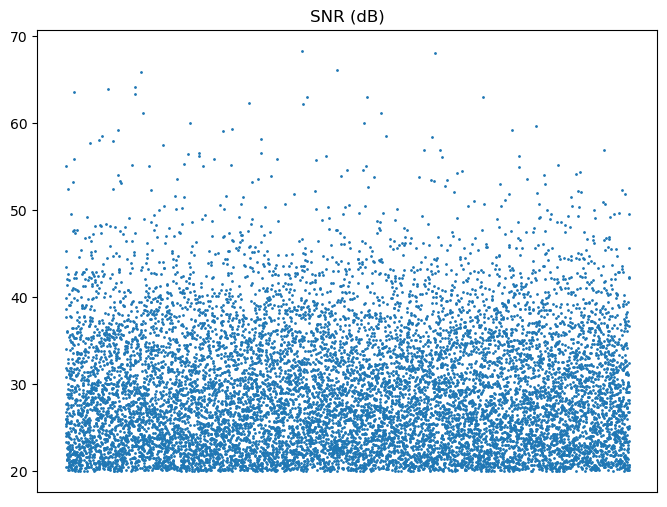

In [24]:
num_high_snr_traces = int(SNR_of_high_SNR_traces.shape[0])
fig, ax_high_snr = plt.subplots(figsize=(8, 6))
ax_high_snr.set_title('SNR (dB)')
ax_high_snr.set_xticklabels([])
ax_high_snr.set_xticks([])
ax_high_snr.scatter(range(num_high_snr_traces), SNR_of_high_SNR_traces, s=1);